Automatic detection of solar type III radio bursts

In [27]:
import warnings
warnings.filterwarnings('ignore')
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.colors import LogNorm
from skimage.transform import probabilistic_hough_line
from ipywidgets import interact, FloatSlider, IntSlider, VBox, Layout
from type3detect import radioTools as rt
from scipy import optimize
from scipy import interpolate

machine = 'dias' # dias or nancep

if machine=='dias': # on dias machines
    data_dir    = '/home/mnedal/data/ORFEES'
    folder_path = '/home/mnedal/data/pkl_files'
    outputs     = '/home/mnedal/data/png'

elif machine=='nancep': # on nancep node
    data_dir    = '/data/mnedal/data'
    folder_path = '/data/mnedal/outputs/data'
    outputs     = '/data/mnedal/outputs/plots'

In [2]:
mydate        = '20250325'
stock_param   = 'stokesI' # stokesI, stokesV_over_I
SRB_groupname = 'typeIII_G3'

## Load NenuFAR radio dynamic spectrum

In [3]:
nenufar_files = sorted(glob.glob(f'{folder_path}/nenufar/*'))
fname = [ file for file in nenufar_files if mydate in file.split('/')[-1] and stock_param in file.split('/')[-1] and SRB_groupname in file.split('/')[-1] ][0]
print(fname)

df_nenufar = pd.read_pickle(fname)

/home/mnedal/data/pkl_files/nenufar/combined_dyspec_20250325_103529_20250325_104000_stokesI_typeIII_G3.pkl


vmin=2.17e+09, vmax=6.41e+10


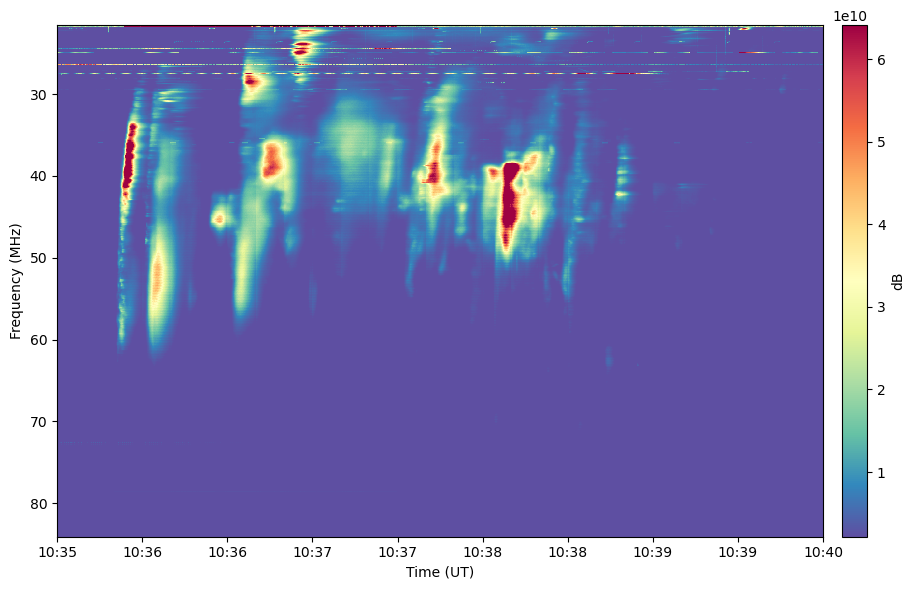

In [10]:
vmin = np.nanpercentile(df_nenufar.values, 70)
vmax = np.nanpercentile(df_nenufar.values, 99.7)
print(f'vmin={vmin:.2e}, vmax={vmax:.2e}')

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(
    df_nenufar.index, 
    df_nenufar.columns, 
    df_nenufar.T, 
    cmap='Spectral_r',
    vmin=vmin,
    vmax=vmax
)
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.invert_yaxis()
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

## Remove the constant background

In [5]:
# Downsample to 1-min resolution
nenufar_nobkg_1s = df_nenufar.resample('1S').mean()

# Remove const background
nenufar_nobkg = nenufar_nobkg_1s - np.tile(np.nanmedian(nenufar_nobkg_1s,0), (nenufar_nobkg_1s.shape[0],1))

vmin=-3.01e+08, vmax5.87e+10


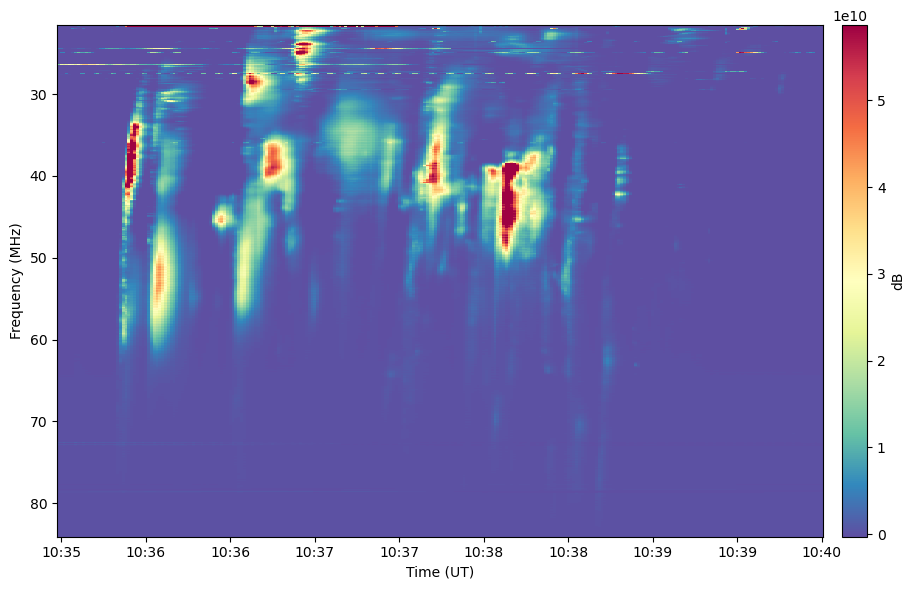

In [11]:
# high-res dyspec
vmin = np.nanpercentile(nenufar_nobkg.values, 25)
vmax = np.nanpercentile(nenufar_nobkg.values, 99.7)
print(f'vmin={vmin:.2e}, vmax{vmax:.2e}')

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(nenufar_nobkg.index, nenufar_nobkg.columns, nenufar_nobkg.T,
                   vmin=vmin, vmax=vmax, cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.invert_yaxis()
ax.xaxis_date()
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

vmin=1.23e+08, vmax6.36e+10


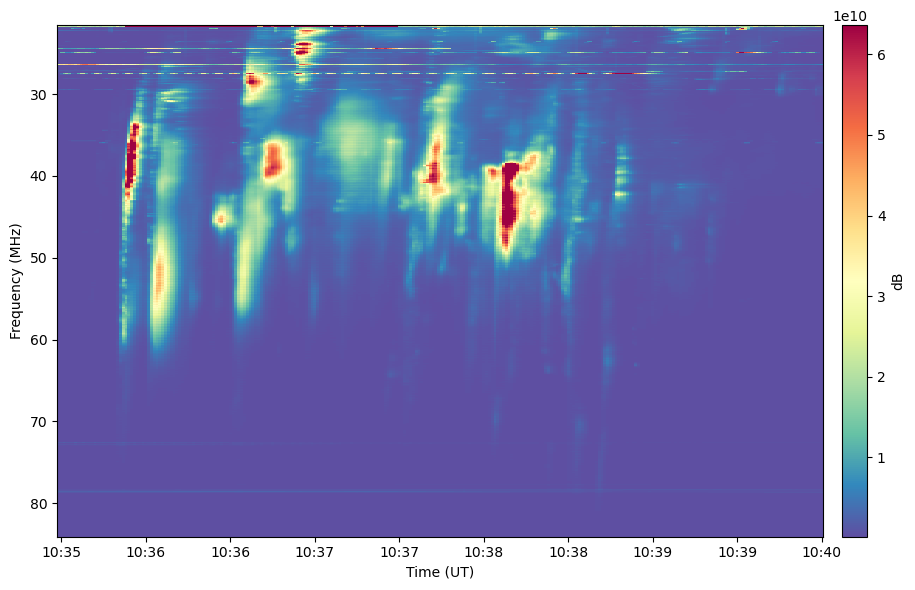

In [12]:
# low-res dyspec
vmin = np.nanpercentile(nenufar_nobkg_1s.values, 25)
vmax = np.nanpercentile(nenufar_nobkg_1s.values, 99.7)
print(f'vmin={vmin:.2e}, vmax{vmax:.2e}')

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(nenufar_nobkg_1s.index, nenufar_nobkg_1s.columns, nenufar_nobkg_1s.T,
                   vmin=vmin, vmax=vmax, cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.invert_yaxis()
ax.xaxis_date()
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

In [171]:
# from skimage.transform import probabilistic_hough_line
# from skimage.filters import threshold_otsu
# import ipywidgets as widgets
# from ipywidgets import interact, FloatSlider, IntSlider, VBox, Layout



# def update_hough(vmin=80, vmax=99.9, threshold=50, line_gap=50, line_length=35):
#     # Apply dynamic binarization
#     data = nenufar_nobkg_1s.copy()
#     vmin_val = np.percentile(data, vmin)
#     vmax_val = np.percentile(data, vmax)
#     norm_data = np.clip((data - vmin_val) / (vmax_val - vmin_val), 0, 1)
#     binary = norm_data > threshold_otsu(norm_data.values)
    
#     # Detect lines
#     theta = np.linspace(np.pi/2 - np.pi/8, np.pi/2 - 1/180*np.pi, 300)
#     lines = probabilistic_hough_line(binary.values, threshold=threshold,
#                                      line_gap=line_gap, line_length=line_length,
#                                      theta=theta)

#     # Plotting
#     fig, axs = plt.subplots(1, 3, figsize=[18,6], sharex=True, sharey=True)

#     axs[0].imshow(binary.T, cmap='gray', origin='lower', aspect='auto')
#     axs[0].set_title('Binary Map')

#     axs[1].imshow(binary.T, cmap='gray', origin='lower', aspect='auto')
#     for (x0, y0), (x1, y1) in lines:
#         axs[1].plot([y0, y1], [x0, x1], 'r', linewidth=1)
#     axs[1].set_title('Hough Lines on Binary Map')

#     vmin = np.percentile(nenufar_nobkg_1s.values, 70)
#     vmax = np.percentile(nenufar_nobkg_1s.values, 99.7)
#     axs[2].imshow(nenufar_nobkg_1s.T, 
#                   origin='lower', aspect='auto',
#                   vmin=vmin, vmax=vmax,
#                   cmap='Spectral_r')
#     for (x0, y0), (x1, y1) in lines:
#         axs[2].plot([y0, y1], [x0, x1], 'k', linewidth=1)
#     axs[2].set_title('Hough Lines on Dynamic Spectrum')
    
#     fig.tight_layout()
#     plt.show()

# # Interactive sliders with longer layout
# vmin_slider = FloatSlider(min=0, max=100, step=0.5, value=80, description='vmin %',
#                           layout=Layout(width='800px'))
# vmax_slider = FloatSlider(min=0, max=100, step=0.1, value=99.9, description='vmax %',
#                           layout=Layout(width='800px'))
# threshold_slider = IntSlider(min=10, max=500, step=1, value=50, description='Threshold',
#                              layout=Layout(width='800px'))
# line_gap_slider = IntSlider(min=1, max=1000, step=1, value=50, description='Line Gap',
#                             layout=Layout(width='800px'))
# line_length_slider = IntSlider(min=1, max=500, step=1, value=35, description='Line Length',
#                                layout=Layout(width='800px'))

# interact_ui = VBox([
#     vmin_slider,
#     vmax_slider,
#     threshold_slider,
#     line_gap_slider,
#     line_length_slider
# ])

# interact(update_hough,
#          vmin=vmin_slider,
#          vmax=vmax_slider,
#          threshold=threshold_slider,
#          line_gap=line_gap_slider,
#          line_length=line_length_slider)

# # display(interact_ui)

interactive(children=(FloatSlider(value=80.0, description='vmin %', layout=Layout(width='800px'), step=0.5), F…

<function __main__.update_hough(vmin=80, vmax=99.9, threshold=50, line_gap=50, line_length=35)>

In [180]:
# # Your binarization function
# def binarization(dyspec, N_order=6, peak_r=0.99):
#     ''' convert array into binary map '''
#     bmap = np.ones_like(dyspec, dtype=bool)
#     N_pad = N_order
#     local_max_arr = np.pad(dyspec, ((N_pad, N_pad), (0, 0)))
#     for idx in range(N_pad - 1):
#         bmap = bmap * (
#             (peak_r * local_max_arr[N_pad + idx + 1:-N_pad + idx + 1, :] < local_max_arr[N_pad + idx:-N_pad + idx, :]) &
#             (peak_r * local_max_arr[N_pad - idx - 1:-N_pad - idx - 1, :] < local_max_arr[N_pad - idx:-N_pad - idx, :])
#         )
#     return bmap

# # Interactive function to visualize binarization
# def update_binary_map(N_order, peak_r):
#     bmap = binarization(nenufar_nobkg_1s, N_order=N_order, peak_r=peak_r)
    
#     plt.figure(figsize=(10,6))
#     plt.imshow(bmap.T, origin='lower', aspect='auto', cmap='gray')
#     plt.title(f'Binary Map | N_order={N_order}, peak_r={peak_r:.3f}')
#     plt.xlabel('Time')
#     plt.ylabel('Frequency')
#     plt.grid(False)
#     plt.show()

# # Sliders
# interact(
#     update_binary_map,
#     N_order=IntSlider(value=6, min=1, max=20, step=1, description='N_order:', continuous_update=False, layout=widgets.Layout(width='800px')),
#     peak_r=FloatSlider(value=0.99, min=0.1, max=1.0, step=0.005, description='peak_r:', continuous_update=False, layout=widgets.Layout(width='800px'))
# );

interactive(children=(IntSlider(value=6, continuous_update=False, description='N_order:', layout=Layout(width=…

In [186]:
# import numpy as np
# import matplotlib.pyplot as plt
# from skimage.transform import probabilistic_hough_line
# from skimage.filters import threshold_otsu
# import ipywidgets as widgets
# from ipywidgets import interact, FloatSlider, IntSlider, VBox, Layout


# # -------------------------------
# # Binarization function
# # -------------------------------
# def binarization(dyspec, N_order=6, peak_r=0.99):
#     ''' Convert array into binary map '''
#     bmap = np.ones_like(dyspec, dtype=bool)
#     N_pad = N_order
#     local_max_arr = np.pad(dyspec, ((N_pad, N_pad), (0, 0)))
#     for idx in range(N_pad - 1):
#         bmap = bmap * (
#             (peak_r * local_max_arr[N_pad + idx + 1:-N_pad + idx + 1, :] < local_max_arr[N_pad + idx:-N_pad + idx, :]) &
#             (peak_r * local_max_arr[N_pad - idx - 1:-N_pad - idx - 1, :] < local_max_arr[N_pad - idx:-N_pad - idx, :])
#         )
#     return bmap


# # -------------------------------
# # Interactive Hough + Binarization viewer
# # -------------------------------
# def update_hough(vmin=80, vmax=99.9, threshold=50, line_gap=50, line_length=35,
#                  theta_min_deg=50, theta_max_deg=89, N_order=6, peak_r=0.99):
    
#     # Normalize and binarize
#     data = nenufar_nobkg_1s.copy()
#     vmin_val = np.percentile(data, vmin)
#     vmax_val = np.percentile(data, vmax)
#     norm_data = np.clip((data - vmin_val) / (vmax_val - vmin_val), 0, 1)
    
#     # Binarization using custom method
#     binary = binarization(norm_data.values, N_order=N_order, peak_r=peak_r)

#     # Hough lines
#     theta = np.linspace(np.deg2rad(theta_min_deg), np.deg2rad(theta_max_deg), 300)
#     lines = probabilistic_hough_line(binary, threshold=threshold,
#                                      line_gap=line_gap, line_length=line_length,
#                                      theta=theta)

#     # Plotting
#     fig, axs = plt.subplots(1, 3, figsize=[18, 6], sharex=True, sharey=True)

#     axs[0].imshow(binary.T, cmap='gray', origin='lower', aspect='auto')
#     axs[0].set_title('Binary Map')

#     axs[1].imshow(binary.T, cmap='gray', origin='lower', aspect='auto')
#     for (x0, y0), (x1, y1) in lines:
#         axs[1].plot([y0, y1], [x0, x1], 'r', linewidth=1)
#     axs[1].set_title('Hough Lines on Binary Map')

#     # Dynamic Spectrum with lines
#     v1 = np.percentile(data.values, 70)
#     v2 = np.percentile(data.values, 99.7)
#     axs[2].imshow(data.T, origin='lower', aspect='auto', cmap='Spectral_r',
#                   vmin=v1, vmax=v2)
#     for (x0, y0), (x1, y1) in lines:
#         axs[2].plot([y0, y1], [x0, x1], 'k', linewidth=1)
#     axs[2].set_title('Hough Lines on Dynamic Spectrum')

#     fig.tight_layout()
#     plt.show()


# # -------------------------------
# # Sliders
# # -------------------------------
# layout = Layout(width='800px')

# vmin_slider = FloatSlider(min=0, max=100, step=0.5, value=80, description='vmin %', layout=layout)
# vmax_slider = FloatSlider(min=0, max=100, step=0.1, value=99.9, description='vmax %', layout=layout)
# threshold_slider = IntSlider(min=10, max=500, step=1, value=50, description='Threshold', layout=layout)
# line_gap_slider = IntSlider(min=1, max=1000, step=1, value=50, description='Line Gap', layout=layout)
# line_length_slider = IntSlider(min=1, max=500, step=1, value=35, description='Line Length', layout=layout)
# theta_min_slider = IntSlider(min=0, max=89, step=1, value=50, description='Theta min (°)', layout=layout)
# theta_max_slider = IntSlider(min=1, max=90, step=1, value=89, description='Theta max (°)', layout=layout)
# norder_slider = IntSlider(min=1, max=20, step=1, value=6, description='N_order', layout=layout)
# peakr_slider = FloatSlider(min=0.8, max=1.0, step=0.005, value=0.99, description='peak_r', layout=layout)

# # Display widgets
# interact_ui = VBox([
#     vmin_slider,
#     vmax_slider,
#     threshold_slider,
#     line_gap_slider,
#     line_length_slider,
#     theta_min_slider,
#     theta_max_slider,
#     norder_slider,
#     peakr_slider
# ])

# interact(update_hough,
#          vmin=vmin_slider,
#          vmax=vmax_slider,
#          threshold=threshold_slider,
#          line_gap=line_gap_slider,
#          line_length=line_length_slider,
#          theta_min_deg=theta_min_slider,
#          theta_max_deg=theta_max_slider,
#          N_order=norder_slider,
#          peak_r=peakr_slider)

interactive(children=(FloatSlider(value=80.0, description='vmin %', layout=Layout(width='800px'), step=0.5), F…

<function __main__.update_hough(vmin=80, vmax=99.9, threshold=50, line_gap=50, line_length=35, theta_min_deg=50, theta_max_deg=89, N_order=6, peak_r=0.99)>

In [15]:


# # =======================
# # Binarization Function
# # =======================
# def binarization(dyspec, N_order=6, peak_r=0.99):
#     ''' Convert array into binary map '''
#     bmap = np.ones_like(dyspec, dtype=bool)
#     N_pad = N_order
#     local_max_arr = np.pad(dyspec, ((N_pad, N_pad), (0, 0)))
#     for idx in range(N_pad - 1):
#         bmap = bmap * (
#             (peak_r * local_max_arr[N_pad + idx + 1:-N_pad + idx + 1, :] < local_max_arr[N_pad + idx:-N_pad + idx, :]) &
#             (peak_r * local_max_arr[N_pad - idx - 1:-N_pad - idx - 1, :] < local_max_arr[N_pad - idx:-N_pad - idx, :])
#         )
#     return bmap

# # =======================
# # Line Grouping Functions
# # =======================
# def point_to_line_distance(p1, p2, p3):
#     return np.abs(np.linalg.norm(np.cross(p2 - p1, p1 - p3))) / np.linalg.norm(p2 - p1)

# def line_grouping(lines, dist_thresh=2.5):
#     lines = sorted(lines, key=lambda i: i[0][1])
#     if not lines:
#         return []

#     line_sets = [[lines[0]]]
#     for idx in range(len(lines) - 1):
#         A, B = np.array(lines[idx])
#         C, D = np.array(lines[idx + 1])
#         dist = np.min([point_to_line_distance(A, B, C), point_to_line_distance(A, B, D)])
#         if dist < dist_thresh:
#             line_sets[-1].append(lines[idx + 1])
#         else:
#             line_sets.append([lines[idx + 1]])
#     return line_sets

# # =======================
# # Main Update Function
# # =======================
# def update_hough(vmin=80, vmax=99.9, N_order=6, peak_r=0.99,
#                  threshold=50, line_gap=50, line_length=35,
#                  theta_min_deg=67, theta_max_deg=82, dist_thresh=2.5):

#     data = nenufar_nobkg_1s.copy()
    
#     # Normalize
#     vmin_val = np.nanpercentile(data, vmin)
#     vmax_val = np.nanpercentile(data, vmax)
#     norm_data = np.clip((data - vmin_val) / (vmax_val - vmin_val), 0, 1)

#     # Custom binarization
#     binary = binarization(norm_data.values, N_order=N_order, peak_r=peak_r)

#     # Hough transform
#     theta_min = np.deg2rad(theta_min_deg)
#     theta_max = np.deg2rad(theta_max_deg)
#     theta = np.linspace(theta_min, theta_max, 300)

#     lines = probabilistic_hough_line(binary, threshold=threshold,
#                                      line_gap=line_gap, line_length=line_length,
#                                      theta=theta)

#     # Group lines
#     line_sets = line_grouping(lines, dist_thresh=dist_thresh)

#     # Plotting
#     fig, axs = plt.subplots(1, 3, figsize=[18,6], sharex=True, sharey=True)

#     axs[0].imshow(binary.T, cmap='gray', origin='lower', aspect='auto')
#     axs[0].set_title('Binary Map')

#     axs[1].imshow(binary.T, cmap='gray', origin='lower', aspect='auto')
#     for idx, lineset in enumerate(line_sets):
#         for line in lineset:
#             p0, p1 = line
#             axs[1].plot((p0[1], p1[1]), (p0[0], p1[0]), color=f'C{idx % 10}')
#             axs[1].plot((p0[1], p1[1]), (p0[0], p1[0]), 'k+', zorder=10)
#     axs[1].set_title('Grouped Hough Lines')

#     vmin_spec = np.nanpercentile(data, 25)
#     vmax_spec = np.nanpercentile(data, 99.7)
#     axs[2].imshow(data.T, origin='lower', aspect='auto',
#                   vmin=vmin_spec, vmax=vmax_spec, cmap='Spectral_r')
#     for idx, lineset in enumerate(line_sets):
#         for line in lineset:
#             p0, p1 = line
#             axs[2].plot((p0[1], p1[1]), (p0[0], p1[0]), color=f'C{idx % 10}')
#             axs[2].plot((p0[1], p1[1]), (p0[0], p1[0]), 'k+', zorder=10)
#     axs[2].set_title('Grouped Lines on Spectrum')

#     fig.tight_layout()
#     plt.show()

# # =======================
# # Interactive Sliders (800px wide)
# # =======================
# layout800 = Layout(width='800px')

# vmin_slider = FloatSlider(min=0, max=100, step=0.1, value=80, description='vmin %', layout=layout800)
# vmax_slider = FloatSlider(min=0, max=100, step=0.1, value=99.9, description='vmax %', layout=layout800)

# N_order_slider = IntSlider(min=1, max=20, step=1, value=6, description='N_order', layout=layout800)
# peak_r_slider = FloatSlider(min=0.1, max=2.0, step=0.005, value=1, description='peak_r', layout=layout800)

# threshold_slider = IntSlider(min=10, max=1000, step=1, value=77, description='Threshold', layout=layout800)
# line_gap_slider = IntSlider(min=1, max=1000, step=1, value=50, description='Line Gap', layout=layout800)
# line_length_slider = IntSlider(min=1, max=1000, step=1, value=35, description='Line Length', layout=layout800)

# theta_min_slider = FloatSlider(min=0, max=90, step=0.5, value=80, description='Theta Min (°)', layout=layout800)
# theta_max_slider = FloatSlider(min=0, max=90, step=0.5, value=90, description='Theta Max (°)', layout=layout800)

# dist_thresh_slider = FloatSlider(min=0.1, max=50.0, step=0.1, value=2, description='Dist Thresh', layout=layout800)

# interact_ui = VBox([
#     vmin_slider,
#     vmax_slider,
#     N_order_slider,
#     peak_r_slider,
#     threshold_slider,
#     line_gap_slider,
#     line_length_slider,
#     theta_min_slider,
#     theta_max_slider,
#     dist_thresh_slider
# ])

# interact(update_hough,
#          vmin=vmin_slider,
#          vmax=vmax_slider,
#          N_order=N_order_slider,
#          peak_r=peak_r_slider,
#          threshold=threshold_slider,
#          line_gap=line_gap_slider,
#          line_length=line_length_slider,
#          theta_min_deg=theta_min_slider,
#          theta_max_deg=theta_max_slider,
#          dist_thresh=dist_thresh_slider)

interactive(children=(FloatSlider(value=80.0, description='vmin %', layout=Layout(width='800px')), FloatSlider…

<function __main__.update_hough(vmin=80, vmax=99.9, N_order=6, peak_r=0.99, threshold=50, line_gap=50, line_length=35, theta_min_deg=67, theta_max_deg=82, dist_thresh=2.5)>

In [44]:
# # =======================
# # Binarization Function
# # =======================
# def binarization(dyspec, N_order=6, peak_r=0.99):
#     ''' Convert array into binary map '''
#     bmap = np.ones_like(dyspec, dtype=bool)
#     N_pad = N_order
#     local_max_arr = np.pad(dyspec, ((N_pad, N_pad), (0, 0)))
#     for idx in range(N_pad - 1):
#         bmap = bmap * (
#             (peak_r * local_max_arr[N_pad + idx + 1:-N_pad + idx + 1, :] < local_max_arr[N_pad + idx:-N_pad + idx, :]) &
#             (peak_r * local_max_arr[N_pad - idx - 1:-N_pad - idx - 1, :] < local_max_arr[N_pad - idx:-N_pad - idx, :])
#         )
#     return bmap

# # =======================
# # Line Grouping Functions
# # =======================
# def point_to_line_distance(p1, p2, p3):
#     return np.abs(np.linalg.norm(np.cross(p2 - p1, p1 - p3))) / np.linalg.norm(p2 - p1)

# def line_grouping(lines, dist_thresh=2.5):
#     lines = sorted(lines, key=lambda i: i[0][1])
#     if not lines:
#         return []

#     line_sets = [[lines[0]]]
#     for idx in range(len(lines) - 1):
#         A, B = np.array(lines[idx])
#         C, D = np.array(lines[idx + 1])
#         dist = np.min([point_to_line_distance(A, B, C), point_to_line_distance(A, B, D)])
#         if dist < dist_thresh:
#             line_sets[-1].append(lines[idx + 1])
#         else:
#             line_sets.append([lines[idx + 1]])
#     return line_sets


# def get_info_from_linegroup(line_sets, t_fits, f_fits):
#     # mapping from t and f to index of x and y
#     t_idx_arr = np.arange(0, t_fits.shape[0])
#     f_idx_arr = np.arange(0, f_fits.shape[0])
#     t_interf = interpolate.interp1d(t_idx_arr, t_fits, fill_value='extrapolate')
#     f_interf = interpolate.interp1d(f_idx_arr, f_fits, fill_value='extrapolate')
    
#     v_beam = []
#     f_range_burst = []
#     t_range_burst = []
#     model_curve_set = []
#     t_set_arr_set = []
#     f_set_arr_set = []
#     t_model_idx_arr = []  # Store model curves in pixel coordinates
#     f_model_idx_arr = []

#     for lines in line_sets:
#         if len(lines)==1:
#             continue
#         try:
#             x_set = []
#             y_set = []
#             for line in lines:
#                 x_set.append(line[0][1])
#                 x_set.append(line[1][1])
#                 y_set.append(line[0][0])
#                 y_set.append(line[1][0])

#             t_set_arr = (t_interf(x_set) - np.min(t_fits))*24*3600
#             f_set_arr = f_interf(y_set)

#             popt, pcov = optimize.curve_fit(rt.freq_drift_f_t,
#                                             t_set_arr, f_set_arr, p0=(0.1, np.min(t_set_arr)-3/3600/24), method='lm')

#             t_model_arr  = np.linspace(rt.freq_drift_t_f(np.min(f_set_arr), *popt), 
#                                        rt.freq_drift_t_f(np.max(f_set_arr), *popt), 50) 
#             f_model_arr = rt.freq_drift_f_t(t_model_arr, popt[0], popt[1])

#             # Convert back to pixel coordinates for plotting
#             t_model_physical = t_model_arr/(24*3600) + np.min(t_fits)
            
#             # Create inverse interpolation functions to get pixel coordinates
#             t_inv_interf = interpolate.interp1d(t_fits, t_idx_arr, fill_value='extrapolate')
#             f_inv_interf = interpolate.interp1d(f_fits, f_idx_arr, fill_value='extrapolate')
            
#             t_model_idx = t_inv_interf(t_model_physical)
#             f_model_idx = f_inv_interf(f_model_arr)

#             model_curve_set.append([t_model_physical, f_model_arr])  # Keep physical units for return
#             t_model_idx_arr.append(t_model_idx)  # Store pixel coordinates for plotting
#             f_model_idx_arr.append(f_model_idx)
            
#             t_range_burst.append([rt.freq_drift_t_f(np.min(f_set_arr), *popt)[0]/(24*3600)+np.min(t_fits),
#                                   rt.freq_drift_t_f(np.max(f_set_arr), *popt)[0]/(24*3600)+np.min(t_fits)])
#             f_range_burst.append([np.min(f_set_arr), np.max(f_set_arr)])
#             v_beam.append(popt[0])
#             t_set_arr_set.append(t_set_arr)
#             f_set_arr_set.append(f_set_arr)
#         except:
#             pass
    
#     return (v_beam,
#             f_range_burst,
#             t_range_burst,
#             model_curve_set, 
#             t_set_arr_set,
#             f_set_arr_set,
#             t_model_idx_arr,
#             f_model_idx_arr)


# # =======================
# # Main Update Function
# # =======================
# def update_hough(vmin=80, vmax=99.9, N_order=6, peak_r=0.99,
#                  threshold=50, line_gap=50, line_length=35,
#                  theta_min_deg=67, theta_max_deg=82, dist_thresh=2.5):

        
#     data = nenufar_nobkg_1s.copy()
#     t_fits = mdates.date2num(data.index)
#     f_fits = data.columns.values
    
#     # Normalize
#     vmin_val = np.nanpercentile(data, vmin)
#     vmax_val = np.nanpercentile(data, vmax)
#     norm_data = np.clip((data - vmin_val) / (vmax_val - vmin_val), 0, 1)

#     # Custom binarization
#     binary = binarization(norm_data.values, N_order=N_order, peak_r=peak_r)

#     # Hough transform
#     theta_min = np.deg2rad(theta_min_deg)
#     theta_max = np.deg2rad(theta_max_deg)
#     theta = np.linspace(theta_min, theta_max, 300)

#     lines = probabilistic_hough_line(binary, threshold=threshold,
#                                      line_gap=line_gap, line_length=line_length,
#                                      theta=theta)

#     # Group lines
#     line_sets = line_grouping(lines, dist_thresh=dist_thresh)

#     # grouping the line segments together
#     (v_beam, f_range_burst, t_range_burst, model_curve_set,
#      t_set_arr_set, f_set_arr_set, t_model_idx_arr, f_model_idx_arr) = get_info_from_linegroup(line_sets, t_fits, f_fits)
    
    
#     # Plotting
#     fig, axs = plt.subplots(1, 3, figsize=[18,6], sharex=True, sharey=True)

#     # Set up proper extent for all plots
#     extent = [0, data.shape[0]-1, 0, data.shape[1]-1]  # Use pixel coordinates consistently
    
#     axs[0].imshow(binary.T, cmap='gray', origin='lower', aspect='auto', extent=extent)
#     axs[0].set_title('Binary Map')

#     axs[1].imshow(binary.T, cmap='gray', origin='lower', aspect='auto', extent=extent)
#     for idx, lineset in enumerate(line_sets):
#         for line in lineset:
#             p0, p1 = line
#             axs[1].plot((p0[1], p1[1]), (p0[0], p1[0]), color=f'C{idx % 10}')
#             axs[1].plot((p0[1], p1[1]), (p0[0], p1[0]), 'k+', zorder=10)
#     axs[1].set_title('Grouped Hough Lines')

#     vmin_spec = np.nanpercentile(data, 25)
#     vmax_spec = np.nanpercentile(data, 99.7)
#     axs[2].imshow(data.T, origin='lower', aspect='auto',
#                   vmin=vmin_spec, vmax=vmax_spec,
#                   extent=extent,  # Use consistent pixel coordinates
#                   cmap='Spectral_r')

#     # Plot model curves using pixel coordinates
#     for idx, (t_model_idx, f_model_idx) in enumerate(zip(t_model_idx_arr, f_model_idx_arr)):
#         axs[2].plot(t_model_idx, f_model_idx, 'k--', linewidth=2)
        
#         # Convert burst ranges to pixel coordinates for plotting
#         t_inv_interf = interpolate.interp1d(t_fits, np.arange(len(t_fits)), fill_value='extrapolate')
#         f_inv_interf = interpolate.interp1d(f_fits, np.arange(len(f_fits)), fill_value='extrapolate')
        
#         t_burst_idx = t_inv_interf(t_range_burst[idx])
#         f_burst_idx = f_inv_interf(f_range_burst[idx])
        
#         axs[2].plot(t_burst_idx, f_burst_idx, 'k+', markersize=8)

#     axs[2].set_title('Grouped Lines on Spectrum')

#     # Set proper axis labels in time/frequency units
#     # Create custom tick labels for time axis
#     # n_ticks = 5
#     # time_indices = np.linspace(0, len(t_fits)-1, n_ticks, dtype=int)
#     # time_labels = [mdates.num2date(t_fits[i]).strftime('%H:%M:%S') for i in time_indices]
    
#     # freq_indices = np.linspace(0, len(f_fits)-1, n_ticks, dtype=int)
#     # freq_labels = [f'{f_fits[i]:.1f}' for i in freq_indices]
    
#     for ax in axs:
#         # ax.set_xticks(time_indices)
#         # ax.set_xticklabels(time_labels)
#         # ax.set_yticks(freq_indices)
#         # ax.set_yticklabels(freq_labels)
#         # ax.set_xlabel('Time')
#         # ax.set_ylabel('Frequency (MHz)')
#         ax.set_xlabel('Time Index')
#         ax.set_ylabel('Frequency Index')
#         # ax.xaxis_date()
#         # ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
    
#     fig.tight_layout()
#     plt.show()

# # =======================
# # Interactive Sliders (800px wide)
# # =======================
# layout800 = Layout(width='800px')

# vmin_slider = FloatSlider(min=0, max=100, step=0.1, value=80, description='vmin %', layout=layout800)
# vmax_slider = FloatSlider(min=0, max=100, step=0.1, value=99.9, description='vmax %', layout=layout800)

# N_order_slider = IntSlider(min=1, max=20, step=1, value=6, description='N_order', layout=layout800)
# peak_r_slider = FloatSlider(min=0.1, max=2.0, step=0.005, value=1, description='peak_r', layout=layout800)

# threshold_slider = IntSlider(min=10, max=1000, step=1, value=77, description='Threshold', layout=layout800)
# line_gap_slider = IntSlider(min=1, max=1000, step=1, value=50, description='Line Gap', layout=layout800)
# line_length_slider = IntSlider(min=1, max=1000, step=1, value=35, description='Line Length', layout=layout800)

# theta_min_slider = FloatSlider(min=0, max=90, step=0.5, value=80, description='Theta Min (°)', layout=layout800)
# theta_max_slider = FloatSlider(min=0, max=90, step=0.5, value=90, description='Theta Max (°)', layout=layout800)

# dist_thresh_slider = FloatSlider(min=0.1, max=50.0, step=0.1, value=2, description='Dist Thresh', layout=layout800)

# interact_ui = VBox([
#     vmin_slider,
#     vmax_slider,
#     N_order_slider,
#     peak_r_slider,
#     threshold_slider,
#     line_gap_slider,
#     line_length_slider,
#     theta_min_slider,
#     theta_max_slider,
#     dist_thresh_slider
# ])

# interact(update_hough,
#          vmin=vmin_slider,
#          vmax=vmax_slider,
#          N_order=N_order_slider,
#          peak_r=peak_r_slider,
#          threshold=threshold_slider,
#          line_gap=line_gap_slider,
#          line_length=line_length_slider,
#          theta_min_deg=theta_min_slider,
#          theta_max_deg=theta_max_slider,
#          dist_thresh=dist_thresh_slider)

interactive(children=(FloatSlider(value=80.0, description='vmin %', layout=Layout(width='800px')), FloatSlider…

<function __main__.update_hough(vmin=80, vmax=99.9, N_order=6, peak_r=0.99, threshold=50, line_gap=50, line_length=35, theta_min_deg=67, theta_max_deg=82, dist_thresh=2.5)>

In [48]:
# =======================
# Binarization Function
# =======================
def binarization(dyspec, N_order=6, peak_r=0.99):
    ''' Convert array into binary map '''
    bmap = np.ones_like(dyspec, dtype=bool)
    N_pad = N_order
    local_max_arr = np.pad(dyspec, ((N_pad, N_pad), (0, 0)))
    for idx in range(N_pad - 1):
        bmap = bmap * (
            (peak_r * local_max_arr[N_pad + idx + 1:-N_pad + idx + 1, :] < local_max_arr[N_pad + idx:-N_pad + idx, :]) &
            (peak_r * local_max_arr[N_pad - idx - 1:-N_pad - idx - 1, :] < local_max_arr[N_pad - idx:-N_pad - idx, :])
        )
    return bmap

# =======================
# Line Grouping Functions
# =======================
def point_to_line_distance(p1, p2, p3):
    return np.abs(np.linalg.norm(np.cross(p2 - p1, p1 - p3))) / np.linalg.norm(p2 - p1)

def line_grouping(lines, dist_thresh=2.5):
    lines = sorted(lines, key=lambda i: i[0][1])
    if not lines:
        return []

    line_sets = [[lines[0]]]
    for idx in range(len(lines) - 1):
        A, B = np.array(lines[idx])
        C, D = np.array(lines[idx + 1])
        dist = np.min([point_to_line_distance(A, B, C), point_to_line_distance(A, B, D)])
        if dist < dist_thresh:
            line_sets[-1].append(lines[idx + 1])
        else:
            line_sets.append([lines[idx + 1]])
    return line_sets


def get_info_from_linegroup(line_sets, t_fits, f_fits):
    # mapping from t and f to index of x and y
    t_idx_arr = np.arange(0, t_fits.shape[0])
    f_idx_arr = np.arange(0, f_fits.shape[0])
    t_interf = interpolate.interp1d(t_idx_arr, t_fits, fill_value='extrapolate')
    f_interf = interpolate.interp1d(f_idx_arr, f_fits, fill_value='extrapolate')
    
    v_beam = []
    f_range_burst = []
    t_range_burst = []
    model_curve_set = []
    t_set_arr_set = []
    f_set_arr_set = []
    t_model_idx_arr = []  # Store model curves in pixel coordinates
    f_model_idx_arr = []

    for lines in line_sets:
        if len(lines)==1:
            continue
        try:
            x_set = []
            y_set = []
            for line in lines:
                x_set.append(line[0][1])
                x_set.append(line[1][1])
                y_set.append(line[0][0])
                y_set.append(line[1][0])

            t_set_arr = (t_interf(x_set) - np.min(t_fits))*24*3600
            f_set_arr = f_interf(y_set)

            popt, pcov = optimize.curve_fit(rt.freq_drift_f_t,
                                            t_set_arr, f_set_arr, p0=(0.1, np.min(t_set_arr)-3/3600/24), method='lm')

            t_model_arr  = np.linspace(rt.freq_drift_t_f(np.min(f_set_arr), *popt), 
                                       rt.freq_drift_t_f(np.max(f_set_arr), *popt), 50) 
            f_model_arr = rt.freq_drift_f_t(t_model_arr, popt[0], popt[1])

            # Convert back to pixel coordinates for plotting
            t_model_physical = t_model_arr/(24*3600) + np.min(t_fits)
            
            # Create inverse interpolation functions to get pixel coordinates
            t_inv_interf = interpolate.interp1d(t_fits, t_idx_arr, fill_value='extrapolate')
            f_inv_interf = interpolate.interp1d(f_fits, f_idx_arr, fill_value='extrapolate')
            
            t_model_idx = t_inv_interf(t_model_physical)
            f_model_idx = f_inv_interf(f_model_arr)

            model_curve_set.append([t_model_physical, f_model_arr])  # Keep physical units for return
            t_model_idx_arr.append(t_model_idx)  # Store pixel coordinates for plotting
            f_model_idx_arr.append(f_model_idx)
            
            t_range_burst.append([rt.freq_drift_t_f(np.min(f_set_arr), *popt)[0]/(24*3600)+np.min(t_fits),
                                  rt.freq_drift_t_f(np.max(f_set_arr), *popt)[0]/(24*3600)+np.min(t_fits)])
            f_range_burst.append([np.min(f_set_arr), np.max(f_set_arr)])
            v_beam.append(popt[0])
            t_set_arr_set.append(t_set_arr)
            f_set_arr_set.append(f_set_arr)
        except:
            pass
    
    return (v_beam,
            f_range_burst,
            t_range_burst,
            model_curve_set, 
            t_set_arr_set,
            f_set_arr_set,
            t_model_idx_arr,
            f_model_idx_arr)


# Global variable to store results
analysis_results = {}

# =======================
# Function to get final results
# =======================
def get_final_results():
    """
    Call this function to get the final analysis results after adjusting parameters.
    Returns a dictionary with all the analysis outputs.
    
    Example usage after parameter tuning:
    1. Adjust the sliders to your desired parameters
    2. Run: final_results = get_final_results()
    3. Access individual lists like: final_results['v_beam']
    """
    return analysis_results

# =======================
# Main Update Function
# =======================
def update_hough(vmin=80, vmax=99.9, N_order=6, peak_r=0.99,
                 threshold=50, line_gap=50, line_length=35,
                 theta_min_deg=67, theta_max_deg=82, dist_thresh=2.5):

        
    data = nenufar_nobkg_1s.copy()
    t_fits = mdates.date2num(data.index)
    f_fits = data.columns.values
    
    # Normalize
    vmin_val = np.nanpercentile(data, vmin)
    vmax_val = np.nanpercentile(data, vmax)
    norm_data = np.clip((data - vmin_val) / (vmax_val - vmin_val), 0, 1)

    # Custom binarization
    binary = binarization(norm_data.values, N_order=N_order, peak_r=peak_r)

    # Hough transform
    theta_min = np.deg2rad(theta_min_deg)
    theta_max = np.deg2rad(theta_max_deg)
    theta = np.linspace(theta_min, theta_max, 300)

    lines = probabilistic_hough_line(binary, threshold=threshold,
                                     line_gap=line_gap, line_length=line_length,
                                     theta=theta)

    # Group lines
    line_sets = line_grouping(lines, dist_thresh=dist_thresh)

    # grouping the line segments together
    (v_beam, f_range_burst, t_range_burst, model_curve_set,
     t_set_arr_set, f_set_arr_set, t_model_idx_arr, f_model_idx_arr) = get_info_from_linegroup(line_sets, t_fits, f_fits)
    
    
    # Plotting
    fig, axs = plt.subplots(1, 3, figsize=[18,6], sharex=True, sharey=True)

    # Set up proper extent for all plots
    extent = [0, data.shape[0]-1, 0, data.shape[1]-1]  # Use pixel coordinates consistently
    
    axs[0].imshow(binary.T, cmap='gray', origin='lower', aspect='auto', extent=extent)
    axs[0].set_title('Binary Map')

    axs[1].imshow(binary.T, cmap='gray', origin='lower', aspect='auto', extent=extent)
    for idx, lineset in enumerate(line_sets):
        for line in lineset:
            p0, p1 = line
            axs[1].plot((p0[1], p1[1]), (p0[0], p1[0]), color=f'C{idx % 10}')
            axs[1].plot((p0[1], p1[1]), (p0[0], p1[0]), 'k+', zorder=10)
    axs[1].set_title('Grouped Hough Lines')

    vmin_spec = np.nanpercentile(data, 25)
    vmax_spec = np.nanpercentile(data, 99.7)
    axs[2].imshow(data.T, origin='lower', aspect='auto',
                  vmin=vmin_spec, vmax=vmax_spec,
                  extent=extent,  # Use consistent pixel coordinates
                  cmap='Spectral_r')

    # Plot model curves using pixel coordinates
    for idx, (t_model_idx, f_model_idx) in enumerate(zip(t_model_idx_arr, f_model_idx_arr)):
        axs[2].plot(t_model_idx, f_model_idx, 'k--', linewidth=2)
        
        # Convert burst ranges to pixel coordinates for plotting
        t_inv_interf = interpolate.interp1d(t_fits, np.arange(len(t_fits)), fill_value='extrapolate')
        f_inv_interf = interpolate.interp1d(f_fits, np.arange(len(f_fits)), fill_value='extrapolate')
        
        t_burst_idx = t_inv_interf(t_range_burst[idx])
        f_burst_idx = f_inv_interf(f_range_burst[idx])
        
        axs[2].plot(t_burst_idx, f_burst_idx, 'k+', markersize=8)

    axs[2].set_title('Grouped Lines on Spectrum')

    # Use default ticks without custom labels
    for ax in axs:
        ax.set_xlabel('Time Index')
        ax.set_ylabel('Frequency Index')

    fig.tight_layout()
    plt.show()
    
    # Store results in global variable for later access
    global analysis_results
    analysis_results = {
        'v_beam': v_beam,
        'f_range_burst': f_range_burst,
        't_range_burst': t_range_burst,
        'model_curve_set': model_curve_set,
        't_set_arr_set': t_set_arr_set,
        'f_set_arr_set': f_set_arr_set,
        't_model_idx_arr': t_model_idx_arr,
        'f_model_idx_arr': f_model_idx_arr
    }
    
    # return analysis_results

# =======================
# Interactive Sliders (800px wide)
# =======================
layout800 = Layout(width='800px')

vmin_slider = FloatSlider(min=0, max=100, step=0.1, value=80, description='vmin %', layout=layout800)
vmax_slider = FloatSlider(min=0, max=100, step=0.1, value=99.9, description='vmax %', layout=layout800)

N_order_slider = IntSlider(min=1, max=20, step=1, value=6, description='N_order', layout=layout800)
peak_r_slider = FloatSlider(min=0.1, max=2.0, step=0.005, value=1, description='peak_r', layout=layout800)

threshold_slider = IntSlider(min=10, max=1000, step=1, value=77, description='Threshold', layout=layout800)
line_gap_slider = IntSlider(min=1, max=1000, step=1, value=50, description='Line Gap', layout=layout800)
line_length_slider = IntSlider(min=1, max=1000, step=1, value=35, description='Line Length', layout=layout800)

theta_min_slider = FloatSlider(min=0, max=90, step=0.5, value=80, description='Theta Min (°)', layout=layout800)
theta_max_slider = FloatSlider(min=0, max=90, step=0.5, value=90, description='Theta Max (°)', layout=layout800)

dist_thresh_slider = FloatSlider(min=0.1, max=50.0, step=0.1, value=2, description='Dist Thresh', layout=layout800)

interact_ui = VBox([
    vmin_slider,
    vmax_slider,
    N_order_slider,
    peak_r_slider,
    threshold_slider,
    line_gap_slider,
    line_length_slider,
    theta_min_slider,
    theta_max_slider,
    dist_thresh_slider
])

interact(update_hough,
         vmin=vmin_slider,
         vmax=vmax_slider,
         N_order=N_order_slider,
         peak_r=peak_r_slider,
         threshold=threshold_slider,
         line_gap=line_gap_slider,
         line_length=line_length_slider,
         theta_min_deg=theta_min_slider,
         theta_max_deg=theta_max_slider,
         dist_thresh=dist_thresh_slider)

interactive(children=(FloatSlider(value=80.0, description='vmin %', layout=Layout(width='800px')), FloatSlider…

<function __main__.update_hough(vmin=80, vmax=99.9, N_order=6, peak_r=0.99, threshold=50, line_gap=50, line_length=35, theta_min_deg=67, theta_max_deg=82, dist_thresh=2.5)>

In [54]:
final_results = get_final_results()
print(final_results)

{'v_beam': [0.10757027568665176, 0.0681772315251892], 'f_range_burst': [[28.5614013671875, 44.5770263671875], [29.0496826171875, 40.9637451171875]], 't_range_burst': [[20172.44253308059, 20172.442481842652], [20172.44290350078, 20172.442839786996]], 'model_curve_set': [[array([[20172.44253308],
       [20172.44253203],
       [20172.44253099],
       [20172.44252994],
       [20172.4425289 ],
       [20172.44252785],
       [20172.44252681],
       [20172.44252576],
       [20172.44252472],
       [20172.44252367],
       [20172.44252262],
       [20172.44252158],
       [20172.44252053],
       [20172.44251949],
       [20172.44251844],
       [20172.4425174 ],
       [20172.44251635],
       [20172.4425153 ],
       [20172.44251426],
       [20172.44251321],
       [20172.44251217],
       [20172.44251112],
       [20172.44251008],
       [20172.44250903],
       [20172.44250798],
       [20172.44250694],
       [20172.44250589],
       [20172.44250485],
       [20172.4425038 ],
    

In [57]:
# speed of electron beams
np.array(final_results['v_beam']).round(2)

array([0.11, 0.07])

---

## Troupleshooting ...

In [113]:
# Select a subset of frequencies (e.g., 10 evenly spaced ones)
num_curves = 10
frequencies = nenufar_nobkg.columns.sort_values()
selected_freqs = frequencies[::len(frequencies)//num_curves]

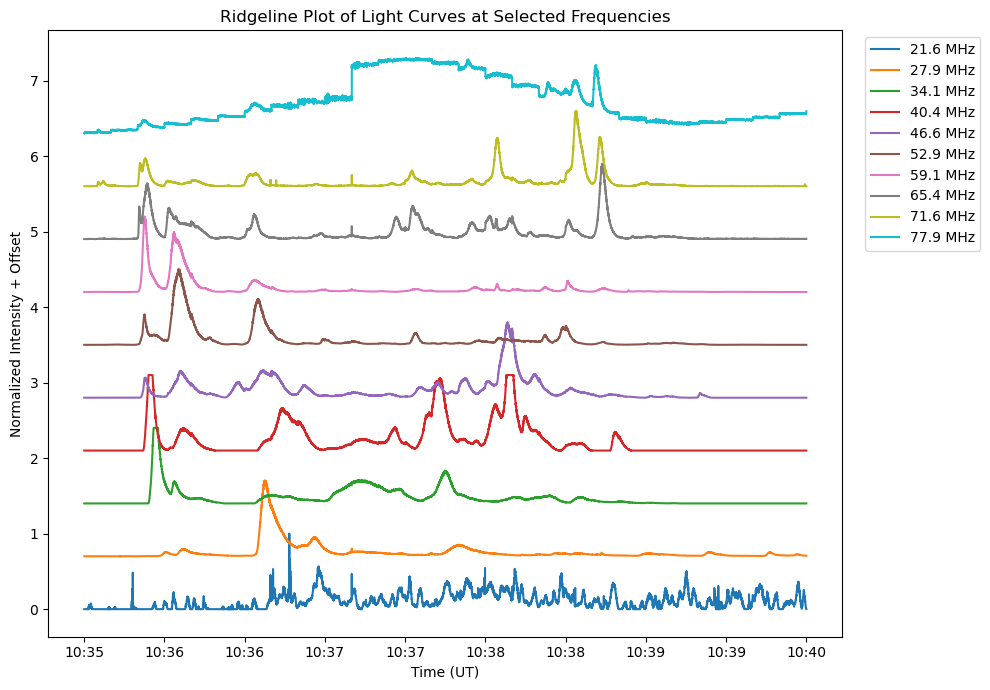

In [127]:
fig, ax = plt.subplots(figsize=[10,7])

offset  = 0
spacing = 0.7  # Vertical spacing between curves

for i, freq in enumerate(selected_freqs):
    curve = nenufar_nobkg[freq]
    times = nenufar_nobkg.index
    
    # Normalize each curve (optional for better visual comparison)
    curve_norm = (curve - curve.min()) / (curve.max() - curve.min())
    
    ax.plot(times, curve_norm+offset, label=f'{freq:.1f} MHz')
    offset += spacing

ax.set_xlabel('Time (UT)')
ax.set_ylabel('Normalized Intensity + Offset')
ax.set_title('Ridgeline Plot of Light Curves at Selected Frequencies')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

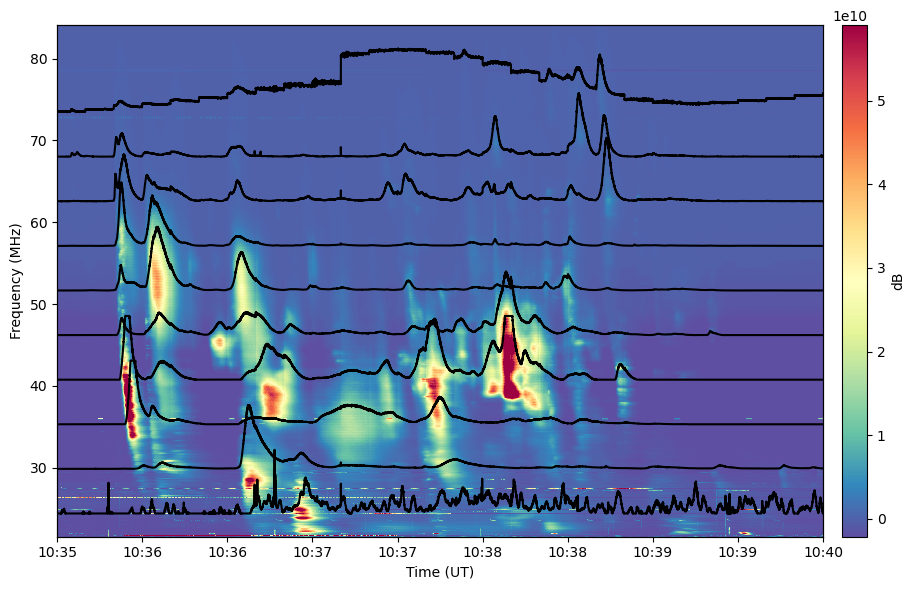

In [135]:
fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)

# --- Dynamic spectrum ---
pc = ax.pcolormesh(
    nenufar_nobkg.index, 
    nenufar_nobkg.columns, 
    nenufar_nobkg.T, 
    cmap='Spectral_r'
)
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')

# --- Overlay normalized light curves ---
offset  = 0
spacing = 0.7  # Vertical spacing between curves
ax2 = ax.twinx()

for i, freq in enumerate(selected_freqs):
    curve = nenufar_nobkg[freq]
    times = nenufar_nobkg.index
    
    # Normalize each curve (optional for better visual comparison)
    curve_norm = (curve - curve.min()) / (curve.max() - curve.min())
    
    ax2.plot(times, curve_norm+offset, color='k', label=f'{freq:.1f} MHz')
    offset += spacing

# --- Remove right y-axis ticks and label ---
ax2.set_yticks([])

# --- Axis formatting ---
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

fig.tight_layout()
plt.show()

In [139]:
df_nenufar = pd.read_pickle(fname)

In [140]:
from scipy.ndimage import median_filter

background = df_nenufar.apply(lambda x: median_filter(x, size=100), axis=0)
df_denoised = df_nenufar - background

# Detect bursts as deviations from median (in dB)
threshold = df_denoised.mean().mean() + 3 * df_denoised.std().mean()
df_thresh = df_denoised > threshold

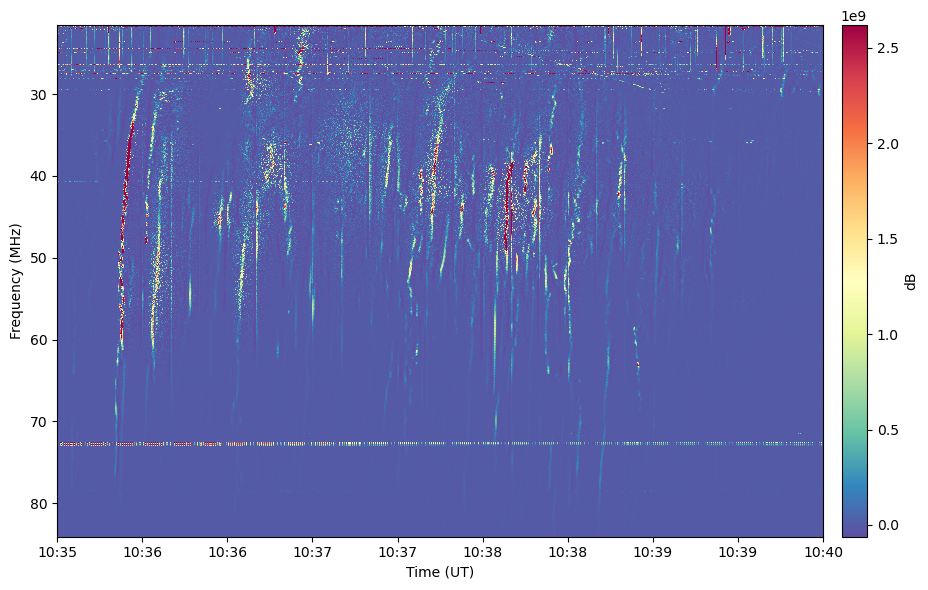

In [144]:
vmin, vmax = np.nanpercentile(df_denoised, [10, 99.7])

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(df_denoised.index, df_denoised.columns, df_denoised.T,
                   vmin=vmin, vmax=vmax,
                   cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_ylim(ax.get_ylim()[::-1])  # Reverse Y axis for frequency descending
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

In [145]:
from scipy.ndimage import label

# Convert boolean DataFrame to 2D array
mask = df_thresh.values.astype(int)
labeled_array, num_features = label(mask)

In [151]:
from sklearn.linear_model import LinearRegression

type_iii_bursts = []

for label_id in range(1, num_features + 1):
    coords = np.argwhere(labeled_array == label_id)
    if coords.shape[0] < 10:
        continue  # Ignore small features

    times = df_nenufar.index[coords[:, 0]].astype(np.int64) // 10**9  # Convert to seconds
    freqs = df_nenufar.columns[coords[:, 1]].astype(float)

    # Linear regression to estimate frequency drift
    model = LinearRegression().fit(times.to_numpy().reshape(-1, 1), freqs)
    drift_rate = model.coef_[0]

    if drift_rate < -0.1:  # negative drift in MHz/s
        type_iii_bursts.append({
            "start_time": df_nenufar.index[min(coords[:, 0])],
            "end_time": df_nenufar.index[max(coords[:, 0])],
            "start_freq": freqs.min(),
            "end_freq": freqs.max(),
            "drift_rate": drift_rate,
        })

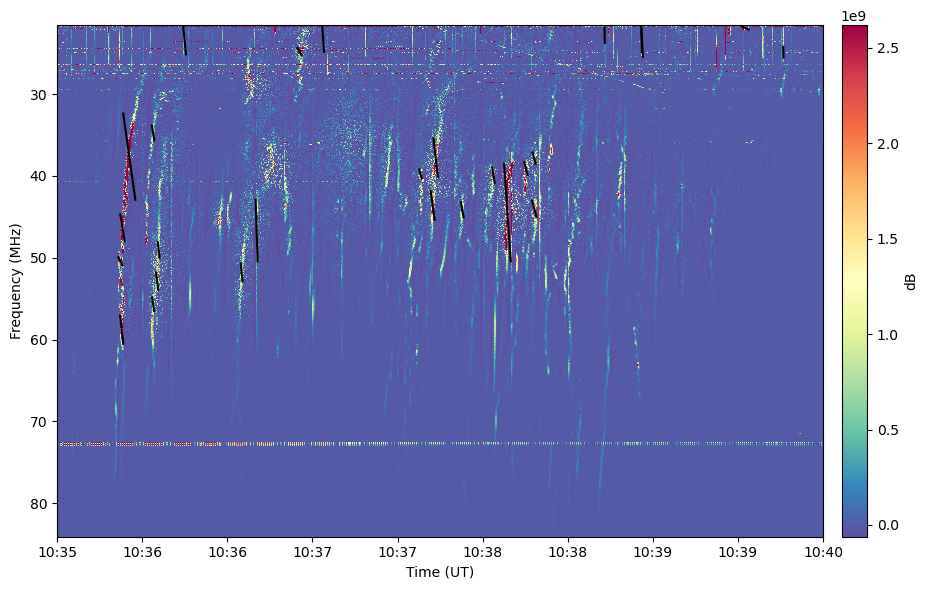

In [154]:
vmin, vmax = np.nanpercentile(df_denoised, [10, 99.7])

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(df_denoised.index, df_denoised.columns, df_denoised.T,
                   vmin=vmin, vmax=vmax,
                   cmap='Spectral_r')

for burst in type_iii_bursts:
    ax.plot([burst['start_time'], burst['end_time']],
             [burst['start_freq'], burst['end_freq']], color='k')

fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_ylim(ax.get_ylim()[::-1])  # Reverse Y axis for frequency descending
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

In [ ]:
from skimage.feature import canny
from skimage.transform import probabilistic_hough_line

# ---------------------------
# 1.  Background removal
# ---------------------------
df = df_nenufar.copy()                               # your dB dynamic spectrum
background = df.apply(lambda x: median_filter(x, size=150), axis=1)
df_denoised = df - background

# ---------------------------
# 2.  Build image (freq rows, time cols)
# ---------------------------
img = df_denoised.T.values                           # shape = (N_freq, N_time)
img = (img - img.min()) / (img.max() - img.min())    # normalise to [0,1]

# ---------------------------
# 3.  Edge detection
# ---------------------------
edges = canny(img, sigma=2)                          # σ≈2 works well for NenuFAR

# ---------------------------
# 4.  Probabilistic Hough
# ---------------------------
lines = probabilistic_hough_line(
    edges,
    threshold=8,          # min votes
    line_length=25,       # ≥ 25 px → ignore speckle
    line_gap=4            # allow small gaps
)

# ---------------------------
# 5.  Convert pixels → phys. coords & filter
# ---------------------------
time_values = df.index.to_numpy()
freq_values = df.columns.astype(float).to_numpy()

def pixel_to_coords(p):                # p = (row, col)
    row, col = p
    f = freq_values[row]               # MHz
    t = time_values[col]               # numpy.datetime64
    return t, f

type_iii_bursts = []
for (p0, p1) in lines:
    t0, f0 = pixel_to_coords(p0)
    t1, f1 = pixel_to_coords(p1)

    # drift rate in MHz s⁻¹
    dt = (t1 - t0) / np.timedelta64(1, 's')
    if dt == 0:
        continue
    drift = (f1 - f0) / dt

    # keep only fast downward drifts
    if drift < -0.5:
        burst = dict(
            start_time=min(t0, t1),
            end_time=max(t0, t1),
            start_freq=max(f0, f1),
            end_freq=min(f0, f1),
            drift_rate_MHz_per_s=drift
        )
        type_iii_bursts.append(burst)

# ---------------------------
# 6.  Plot for sanity-check
# ---------------------------
plt.figure(figsize=(10, 6))
plt.imshow(img, aspect='auto', origin='lower',
           extent=[0, len(time_values), freq_values[0], freq_values[-1]])
for b in type_iii_bursts:
    x0 = np.where(time_values == b['start_time'])[0][0]
    x1 = np.where(time_values == b['end_time'])[0][0]
    plt.plot([x0, x1], [b['start_freq'], b['end_freq']], 'r-', lw=2)
plt.xlabel("Time index")
plt.ylabel("Frequency (MHz)")
plt.title("Type III candidates via Hough transform")
plt.tight_layout()
plt.show()

# ---------------------------
# 7.  Put results in a DataFrame
# ---------------------------
type_iii_df = pd.DataFrame(type_iii_bursts)
display(type_iii_df)